In [115]:
pip install scipy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [116]:
pip install sympy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [257]:
from sympy import combinatorics
from sympy.combinatorics import Permutation, PermutationGroup
from sympy.combinatorics import Polyhedron
from sympy.functions.combinatorial.numbers import stirling, bell
from itertools import permutations
from scipy.stats import chisquare
from numpy.polynomial import Polynomial
import random
import math
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt

## Records count : expected and observable

In [118]:
def count_records_exp(k, n): 
    return stirling(n,k, kind=1) / math.factorial(n)

In [119]:
def gen_selection_for_permutation_group(N, n): 
    group = [Permutation(x) for x in permutations(range(n))]
    size = math.factorial(n)
    if N == size: 
        return group
    elif N < size: 
        return random.sample(group, N)
    else: 
        raise Exception('Incorrect selection size, N = {} should be less n = {}'.format(N, size))

In [120]:
def count_records(permutation: Permutation): 
    maximum = -1
    records = 0 
    for index, elem in enumerate(permutation.list()): 
         if elem > maximum: 
            records += 1
            maximum = elem    
    return records

In [122]:
def analyze_records(selection, n): 
    selection_size = len(selection)
    records_counts_ob, records_counts_exp = [0] * n, [0] * n
    
    length = math.factorial(n)
    for item in selection: 
        records_counts_ob[count_records(item) - 1] += 1
    for i in range(n): 
        records_counts_exp[i] = count_records_exp(i + 1, n) 
        
    (ob, exp) = np.array([float(i / selection_size) for i in records_counts_ob]), np.array([float(i) for i in records_counts_exp])
        
    return chisquare(f_obs=ob, f_exp=exp)

## Shortest cycle length : expected and observable

In [472]:
def expindex(x, M):
    res = x
    for i in range(2, M + 1):
        res += (x**i) / i
    return -res

def nthcoeff(f, x, n):
    res = sym.diff(f, x, n)
    return res.subs(x, 0) / math.factorial(n)

def get_polynom_for_cycle_length(M, n): 
    x = sym.Symbol('x')
    f = 1 - sym.exp(-x) if  M == 0 else sym.exp(expindex(x, M)) - sym.exp(expindex(x, M + 1))
    return nthcoeff(f / (1 - x), x, n)

def short_cycle_length(permutation):
    return min(permutation.cycle_structure.keys())

def get_sum_till_k(k):
    return -sum([1/i for i in range(1, k+1)])

def inf_short_cycle_length(k, n):
    if k == 0: 
        return 1 - exp(-1)
    elif k == (n-1):
        return 1 / n
    else: 
        return exp(get_sum_till_k(k)) - exp(get_sum_till_k(k+1))

In [364]:
def analyze_cycle_length(selection, n): 
    selection_size = len(selection)
    short_cycle_length_ob, short_cycle_length_exp = [0] * n, [0] * n

    length = math.factorial(n)
    for item in selection: 
        short_cycle_length_ob[short_cycle_length(item) - 1] += 1
    for i in range(math.floor(n / 2) + 1): 
        short_cycle_length_exp[i] = get_polynom_for_cycle_length(i, n) 
    short_cycle_length_exp[n-1] = get_polynom_for_cycle_length(n-1, n)
        
    (ob, exp) = np.array([float(i / selection_size) for i in short_cycle_length_ob]), np.array([float(i) for i in short_cycle_length_exp])
    ob = np.trim_zeros(np.sort(ob))
    exp = np.trim_zeros(np.sort(exp))
    
    return chisquare(f_obs=ob, f_exp=exp)

In [476]:
def form(array, n): 
    array = np.array([float(i) for i in array])
    return np.array(array)

def compare_formulas(n_1, n_2):
    inf, coef = [0] * n_2, [0] * n_1
    for i in range(floor(n_1 / 2)): 
        coef[i] = get_polynom_for_cycle_length(i, n_1) 
    for i in range(floor(n_2 / 2)): 
        inf[i] = inf_short_cycle_length(i, n_2)
    coef[n_1-1] = get_polynom_for_cycle_length(n_1-1, n_1)
    inf[n_2-1] = inf_short_cycle_length(n_2-1, n_2)
    
    inf = form(inf, n_2)
    coef = form(coef, n_1)
    
    return (inf, coef)

In [477]:
selection = gen_selection_for_permutation_group(2_000, 10)
analyze_cycle_length(selection, 10)

Power_divergenceResult(statistic=0.0005099288733220997, pvalue=0.9999999996877204)

### Only one graphic

In [478]:
def draw_probabilities(n): 
    (inf, coef) = compare_formulas(n, n)
    x = np.array([i for i in range(1, len(coef) + 1)])
    plt.scatter(x, inf, c='b', marker='x', label='Limit of \"n\" to infinity', alpha=0.5)
    plt.plot(x, inf, c='b', alpha=0.4)
    plt.scatter(x, coef, c='r', marker='s', label='Got \"n\" from coefficients', alpha=0.5)
    plt.plot(x, coef, c='r', alpha=0.4)
    plt.legend(loc='center')
    plt.xlabel('Minimal cycle lengths', fontsize=10, labelpad=18)
    plt.ylabel('Probability', fontsize=10, labelpad=18)
    plt.title('Probabilities for the minimum cycle lengths (n = {})'.format(n), fontsize=14)
    plt.grid()
    plt.show()

### 3 x 3 graphics

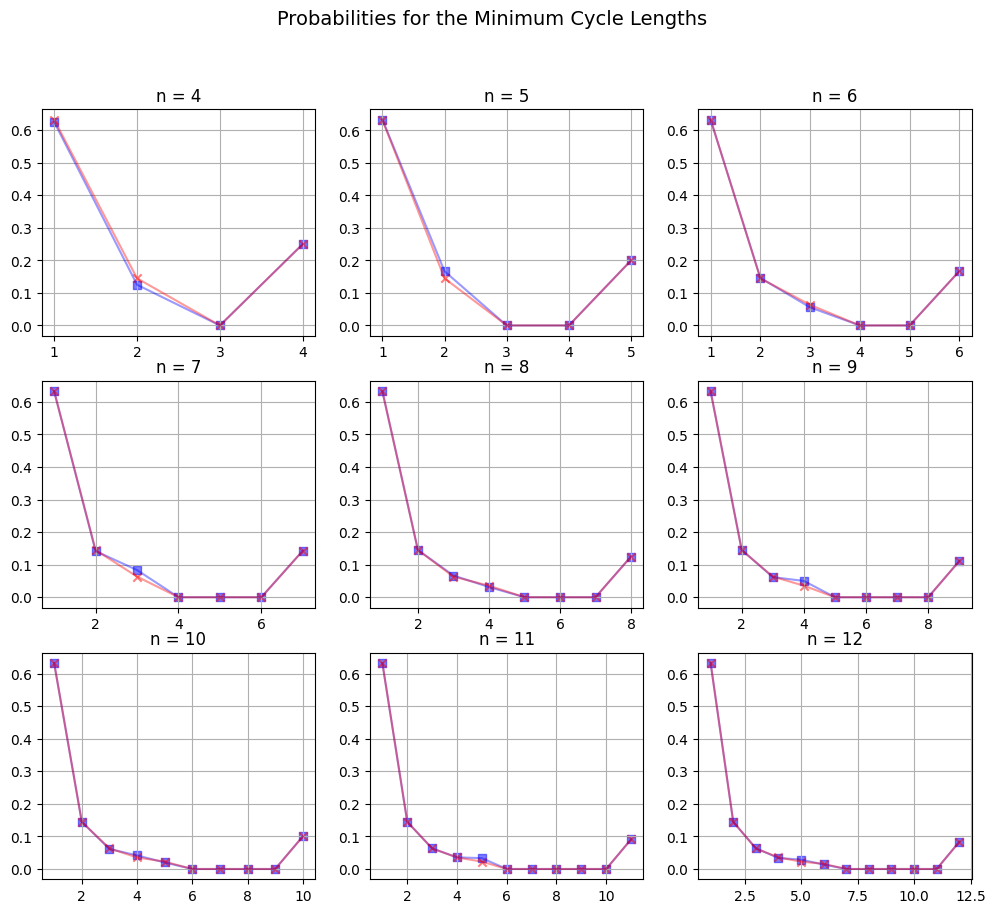

In [519]:
figure, axis = plt.subplots(3, 3, figsize=(12, 10))
figure.suptitle('Probabilities for the Minimum Cycle Lengths', fontsize=14)

for i in range(3):
    for j in range(3): 
        n = i*3 + j + 4
        (inf, coef) = compare_formulas(n, n)
        
        x = np.array([i for i in range(1, len(coef) + 1)]) 

        axis[i, j].scatter(x, coef, c='b', marker='s', label='Got \"n\" from coefficients', alpha=0.5)
        axis[i, j].plot(x, coef, c='b', alpha=0.4)
        
        axis[i, j].scatter(x, inf, c='r', marker='x', label='Limit of \"n\" to infinity', alpha=0.5)
        axis[i, j].plot(x, inf, c='r', alpha=0.4)
        
        axis[i, j].grid()
        axis[i, j].set_title("n = {}".format(n))

plt.show()